In [2]:
pip install pennylane

  Using cached PennyLane-0.29.0-py3-none-any.whl (1.3 MB)
  Using cached PennyLane_Lightning-0.29.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.5 MB)
  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl (15 kB)
  Using cached autoray-0.6.1-py3-none-any.whl (47 kB)
  Using cached autograd-1.5-py3-none-any.whl (48 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade scikit-learn

  Using cached scikit_learn-1.2.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade imbalanced-learn

  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)
Note: you may need to restart the kernel to use updated packages.


In [34]:
# General Imports
import numpy as np
import pandas as pd
import sys
import math

# Visualisation and graphs Imports
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Quantum Imports
# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.utils import algorithm_globals
from qiskit_aer import StatevectorSimulator

# PennyLane Imports
import pennylane as qml
from pennylane.templates import AngleEmbedding, AmplitudeEmbedding

print("All packages imported successfully!")

All packages imported successfully!


## Dataset Information

For this task, we will be using the UCI Machine Learning Repository's Iris dataset. This is perhaps the best known database to be found in the pattern recognition literature. Fisher's paper is a classic in the field and is referenced frequently to this day. (See Duda & Hart, for example.) 

The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are **NOT** linearly separable from each other.

Inputted attribute(s) : sepal length in cm, sepal width in cm, petal length in cm, petal width in cm.

Predicted attribute: class of iris plant.

This is an exceedingly simple domain.

**Note** : This data differs from the data presented in Fishers article (identified by Steve Chadwick, spchadwick '@' espeedaz.net ). The 35th sample should be: [4.9,3.1,1.5,0.2],"Iris-setosa" where the error is in the fourth feature. The 38th sample: [4.9,3.6,1.4,0.1],"Iris-setosa" where the errors are in the second and third features.

Below, is a summary of the critical information regarding the dataset :
- There are 150 samples (instances) in the dataset.

- There are four features (attributes) in each sample.
  - sepal length in cm
  - sepal width in cm
  - petal length in cm
  - petal width in cm

- There are three labels (classes) in the dataset.

  - Iris Setosa
  - Iris Versicolour
  - Iris Virginica 

- The dataset is perfectly balanced (same  number of samples (50) in each class).

- features are not normalized, and their value ranges are different, i.e., [4.3,7.9] and [0.1,2.5] for sepal length and petal width, respectively.

We will start by importing the dataset and defining the **features** and **labels**. 

In [48]:
iris_data = datasets.load_iris() # Load the dataset

In [49]:
features = iris_data.data # The features of the dataset
labels = iris_data.target # The labels of the dataset

We can use Pandas to illustrate some statistics about dataset. First thing that we can observe is the impossibility of a linear separator between the orange and green class.

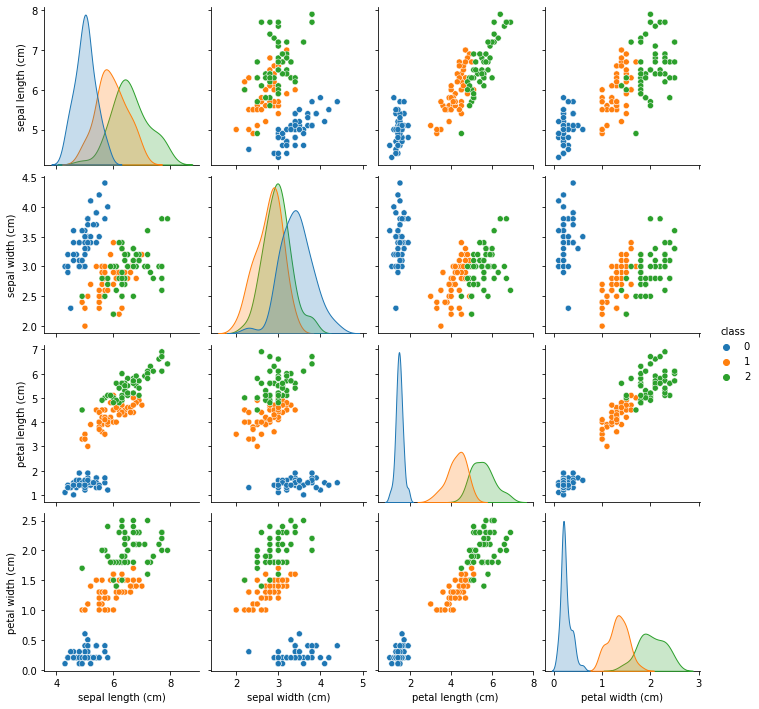

In [5]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

## Dataset Preprocessing

We will be applying two preprocessing steps :

1) Apply PCA to reduce the dimensionality from 4 to 2. (This will linearly decrease the width of our circuit in case of angle encoding)
2) Scale the features to be within a range of [0, 1]. 

In [50]:
pca = PCA(n_components=2) # Initializing PCA
features = pca.fit_transform(features) # Fitting PCA to the features, and deriving two PCs

In [51]:
features = MinMaxScaler().fit_transform(features) # Scaling to range [0,1] 

We can see the distribution of the three classes below. As you can see, the class **Label 1** and **Label 2** are not linearly separable. 

<AxesSubplot:>

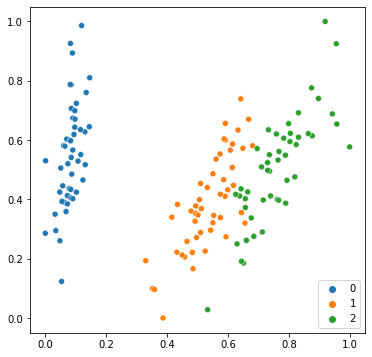

In [8]:
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [61]:
algorithm_globals.random_seed=0 # Set a seed for reproducibility

#split the dataset into two parts: a training dataset and a test dataset
train_features, test_features, train_labels, test_labels = train_test_split(
    features, 
    labels, 
    train_size=0.75, 
    random_state=algorithm_globals.random_seed
)

Below, we will see two samples from the train and test dataset with their respective labels.

In [62]:
print(train_features[0], train_labels[0])
print(test_features[0], test_labels[0])

[0.53216459 0.44012499] 1
[0.68520077 0.27511098] 2


## Training a Classical SVM

For the sake of benchmarking, we will be comparing our QSVM implementation with its classical counterpart, and strive to maintain a 100 percent accuracy for the Quantum implementation as well.

In [63]:
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.97


## QML Pipeline

To create and train any QML model, we will have three main steps :

1. Encoding the Classical data into Quantum states using Quantum Feature Maps. There are four classes of encodings, namely :
    - Amplitude Encoding (RFV)
    - Angle Encoding (ZZFeatureMap)
    - Basis Encoding
    - Arbitrary Encoding

2. Building a Quantum Ansatz/Variational form

3. Training the Quantum Ansatz classically using a classical optimizer, common algorithms are :
    - Stochastic Gradient Descent (SGD)
    - Simultaneous Perturbation Stochastic Approximation (SPSA)
 
![Alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSU0MAp9r7mbdeljWhhQn9UAQTIeH1tIJ6UJg&usqp=CAU "QML Pipeline")
                                  
                  Figure 1

## Building and Training a Quantum Support Vector Machine 

We can see the overall pipeline for QSVM in the figure below :

![Alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3A55nZMzuoRIWK0ydBb7O8VtHnSHChgrOpg&usqp=CAU "QML Pipeline")
                                  
                  Figure 2

## 1. Data Encoding

Data Encoding the process of encoding classical data to quantum states using a quantum feature map.

### **Quantum Feature Maps**

A quantum feature map $\phi(\mathbf{x})$ is a map from the classical feature vector $\mathbf{x}$ to the quantum state $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$. This is done by applying the unitary operation $\mathcal{U}_{\Phi(\mathbf{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding.

**ZZFeatureMap**

For this model, we will be using ZZFeatureMap, which is an angle encoding PQC (Parameterized Quantum Circuit), to encode the iris features into quantum states. Angle encoding is a 1-to-1 encoding, This means we can encode the two PCs using two qubits. 

`ZZFeatureMap` is conjectured to be hard to simulate classically and thus provides an incentive for using QML. This PQC can be implemented using short-depth circuits which makes it a great encoder for low dimensional datasets. 
 
 We will also show how to use Amplitude Encoding for this task as well, using  `RawFeatureVector`. This encoding is best utilized for high dimensional datasets, meaning we can encode the same information using one qubit. 
 
 **RawFeatureVector**
 
We will be using RFV, which is an amplitude encoding PQC, to encode the iris features into quantum states. Unlike angle encoding, amplitude encoding only requires Log2(N) qubits, where _N_ is the number of features in our dataset, which means we can encode the two PCs using one qubit.

The depth of the PQC is 5.


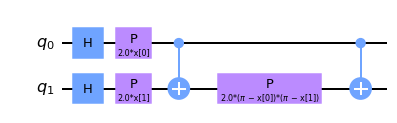

In [52]:
num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
print(f"The depth of the PQC is {str(feature_map.decompose(reps=10).depth())}.")
feature_map.decompose().draw(output="mpl", fold=20)

**Note**: In the above feature map diagram, the parameters $x[0], x[1]$ are placeholders for input features, and since we have two PCs, we will be inputting those as the parameters.

The depth of the PQC is 3.


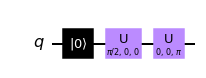

In [64]:
feature_map = RawFeatureVector(feature_dimension = 2**np.log2(num_features)).bind_parameters(np.array([1, -1])*1/np.sqrt(2)) # Initializing and binding RFV to some random state
print(f"The depth of the PQC is {str(feature_map.decompose(reps=10).depth())}.")
feature_map.decompose(reps=15).draw(output="mpl", fold=20)

## 2. Quantum Kernal Estimation

A quantum feature map, $\phi(\mathbf{x})$, naturally gives rise to a quantum kernel, $k(\mathbf{x}_i,\mathbf{x}_j)= \phi(\mathbf{x}_j)^\dagger\phi(\mathbf{x}_i)$, which can be seen as a measure of similarity: $k(\mathbf{x}_i,\mathbf{x}_j)$ is large when $\mathbf{x}_i$ and $\mathbf{x}_j$ are close. 
​
When considering finite data, we can represent the quantum kernel as a matrix: 
$K_{ij} = \left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$
\left| \langle \phi^\dagger(\mathbf{x}_j)| \phi(\mathbf{x}_i) \rangle \right|^{2} = 
\left| \langle 0^{\otimes n} | \mathbf{U_\phi^\dagger}(\mathbf{x}_j) \mathbf{U_\phi}(\mathbf{x_i}) | 0^{\otimes n} \rangle \right|^{2}
$$
assuming the feature map is a parameterized quantum circuit, which can be described as a unitary transformation $\mathbf{U_\phi}(\mathbf{x})$ on $n$ qubits. 
​
This provides us with an estimate of the quantum kernel matrix, which we can then use in a kernel machine learning algorithm, such as support vector classification.

As discussed in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), quantum kernel machine algorithms only have the potential of quantum advantage over classical approaches if the corresponding quantum kernel is hard to estimate **classically**. 

With our training and testing datasets ready, we set up the `QuantumKernel` class with the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and use the `BasicAer` statevector simulator `statevector_simulator` to estimate the training and testing kernel matrices.

Below, we can see what options we have for simulating the statevector, where we can use either CPU or GPU.

In [65]:
backend = StatevectorSimulator(precision='double')
backend.available_devices()

('CPU',)

In [66]:
zz_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=backend)

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

In [67]:
print(train_features[0])
print(test_features[1])

[0.53216459 0.44012499]
[0.49701624 0.2711734 ]


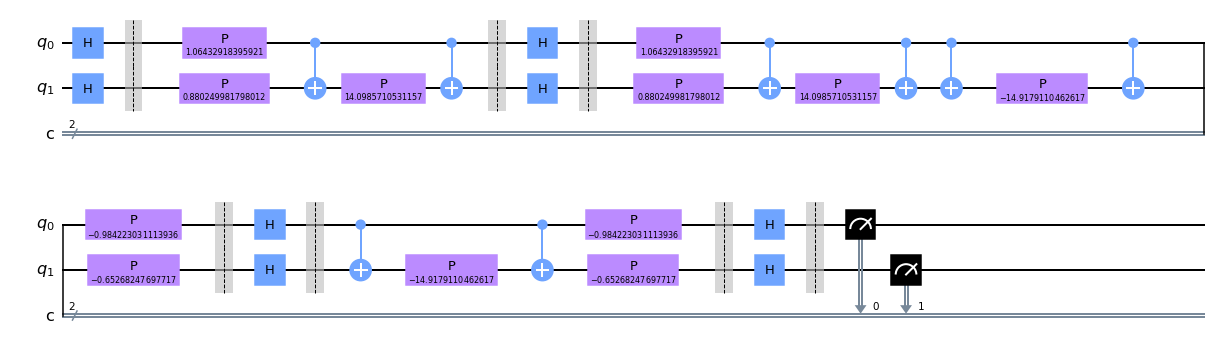

In [68]:
# First Create and draw the circuit
zz_circuit = zz_kernel.construct_circuit(train_features[0], train_features[1])
zz_circuit.decompose(reps=2).draw(output='mpl')

The parameters in the gates are a little difficult to read, but notice how the circuit is symmetrical, with one half encoding one of the data samples, the other half encoding the other. 

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise.


In [69]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

This process is then repeated for each pair of training data samples to fill in the training kernel matrix, and between each training and testing data sample to fill in the testing kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explictly. 

Here we compute and plot the training and testing kernel matrices:

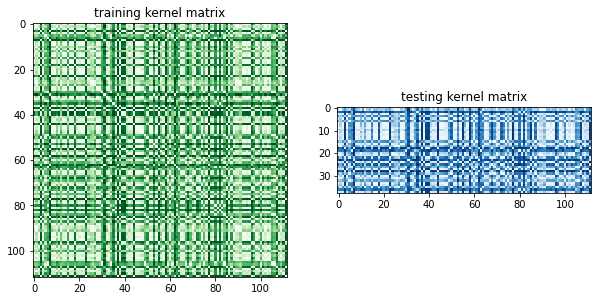

In [70]:
matrix_train = zz_kernel.evaluate(x_vec=train_features)
matrix_test = zz_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Greens_r')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Blues_r')
axs[1].set_title("testing kernel matrix")
plt.show()

## 3. Quantum Support Vector Classification


Introduced in [*Havlicek et al*.  Nature 567, 209-212 (2019)](https://www.nature.com/articles/s41586-019-0980-2), the quantum kernel support vector classification algorithm consists of two steps:

1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

The `scikit-learn` `svc` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in Qiskit.

The following code takes the training and testing kernel matrices we calculated earlier and  provides them to the `scikit-learn` `svc` algorithm:

In [71]:
qsvc = SVC(kernel=zz_kernel.evaluate, decision_function_shape="ovr")
qsvc.fit(train_features, train_labels)
score = qsvc.score(test_features, test_labels)

print('Kernel classification test score: ' + str(score))

Kernel classification test score: 0.6842105263157895


Compare the quantum kernel with various classical kernels:

In [72]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel, decision_function_shape="ovr")
    classical_svc.fit(train_features, train_labels)
    classical_score = classical_svc.score(test_features, test_labels)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.87
poly kernel classification test score:  0.97
rbf kernel classification test score:  0.97
sigmoid kernel classification test score:  0.42


As you can see, the quantum accuracy is quite subpar, let's try to improve that!

## Comparison of Approaches

We have seen a simple implementation of QSVM using Qiskit's ZZFeatureMap, and compared it to its classical counterpart, and yielded an accuracy of 86 percent. In this part, we are going to provide a rigorous treatment of how we can improve the model, and provide a comparison between all the quantum approaches presented. 

### **Comparison Variables**

We are going to try out all possible options for a few defined parameters, namely whether we are using PCA or not, what encoding protocol is used, what **package** is used, and some ML tricks and finally present a complete summary of the QSVM implementation.

For ease in implementation, we are going to convert our steps into a few functions, and create a bigger function which calls these smaller functions with different Comparison variables.

In [4]:
iris_data = datasets.load_iris() # Load the dataset

In [5]:
features = iris_data.data # The features of the dataset
labels = iris_data.target # The labels of the dataset

In [6]:
def preprocess(data, scale, pca):
    """ The preprocess(data, scale, pca) function is used to preprocess data based on the options chose.
    
    Args:
        data (numpy.ndarray): 
            The dataset.
        scale(bin):
            The status of using scaling (True or False).
        pca(np.array):
            The status of using PCA and the number of components to use in an array of length two.

    Returns:
        (numpy.ndarray): The preprocessed dataset.
    """
    if pca[0] is True:
        pca_dev = PCA(n_components=pca[1]) # Initializing PCA
        data = pca_dev.fit_transform(data) # Fitting PCA to the features, and deriving two PCs
    
    if scale is True:
        data = MinMaxScaler().fit_transform(data) # Scale to range [0,1] 
    
    return data # Returning the preprocessed dataset

In [18]:
def classical_SVC(train_features, train_labels, test_features, test_labels):
    """ The classical_SVC(train_features, train_labels) function is used to run the classical implementation of SVM.
    
    Args:
        train_features (numpy.ndarray): 
            The feature values for the training dataset.
        train_labels (np.array):
            The labels for the training dataset.

    Returns:
        (float): Returning train and test dataset accuracy.
    """
    svc = SVC() # Initializing SVC
    _ = svc.fit(train_features, train_labels)  # Suppressing printing the return value

    train_score = svc.score(train_features, train_labels) # The score on the training dataset
    test_score = svc.score(test_features, test_labels) # The score on the test dataset

    return train_score, test_score # Returning train and test dataset accuracy

In [8]:
def angle_embedding_qiskit(qubits, reps):    
    """ The angle_embedding_qiskit(qubits, reps) function is used to construct the quantum kernel using Qiskit's Angle Encoding PQC, ZZFeatureMap.
    
    Args:
        qubits (int): 
            The number of features (is the same as number of qubits since this is angle encoding).
        reps (int):
            The number of repetitions.

    Returns:
        (numpy.ndarray): The kernel matrix.
    """
    backend = StatevectorSimulator(precision='double') # Intializing the StatevectorSimulator for Kernel construction

    zz_map = ZZFeatureMap(feature_dimension=qubits, reps=reps, entanglement='linear', insert_barriers=True) # Initializing the ZZFeatureMap
    zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=backend) # Constructing the kernel
    
    return zz_kernel.evaluate # Returning the Kernel matrix

In [9]:
def angle_embedding_pennylane(qubits):
    """ The angle_embedding_pennylane(qubits) function is used to construct the quantum kernel using PennyLane's Angle Encoding PQC.
    
    Args:
        qubits (int): 
            The number of features (is the same as number of qubits since this is angle encoding).

    Returns:
        (numpy.ndarray): The kernel matrix.
    """
    dev = qml.device("default.qubit", wires=qubits) # Initializing the qml.device
    projector = np.zeros((2**qubits, 2**qubits)) # Initializing the projector
    projector[0, 0] = 1 # Setting the (1,1) element of the matrix to 1

    @qml.qnode(dev)
    def kernel(x1, x2):
        """The kernel(x1, x2) is used to find the value of the kernel matrix for each pair of features.
        
        Args:
            x1 (numpy.ndarray): 
                Classical state.
            x2 (numpy.ndarray): 
                Classical state.
        
        Returns:
            (float): The kernel matrix element (expectation value).
        """
        AngleEmbedding(x1, wires=range(qubits)) # Applying angle embedding 
        qml.adjoint(AngleEmbedding)(x2, wires=range(qubits)) # Applying adjoint angle embedding (to get UU†)
        return qml.expval(qml.Hermitian(projector, wires=range(qubits))) # Returning the expectation value

    def kernel_matrix(A, B):
        """The kernel_matrix(A, B) is used to find the kernel matrix.
        
        Args:
            A (numpy.ndarray): 
                Dataset.
            B (numpy.ndarray): 
                Dataset.
        
        Returns:
            (float): The kernel matrix element (expectation value).
        """
        return np.array([[kernel(a, b) for b in B] for a in A])
    
    return kernel_matrix # Returning the kernel matrix

In [10]:
def amplitude_embedding_qiskit(num_features): 
    """ The amplitude_embedding_qiskit(num_features) function is used to construct the quantum kernel using Qiskit's Amplitude Encoding PQC, RawFeatureVector.
    
    Args:
        num_features (int): 
            The number of features (which must be a power of 2).

    Returns:
        (np.ndarray): The kernel matrix.
    """
    backend = StatevectorSimulator(precision='double') # Intializing the StatevectorSimulator for Kernel construction
    
    # Protocol to make sure the number of features is a power of two
    if math.ceil(np.log2(num_features)) == math.floor(np.log2(num_features)):
        num_features = num_features
        
    else:
        sys.exit("The number of features is not a power of 2. Either adjust the number of features, or pad the dataset.")

    rfv_map = RawFeatureVector(feature_dimension=num_features) # Initializing the RawFeatureVector
    rfv_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=backend) # Constructing the kernel
    
    return rfv_kernel.evaluate

In [11]:
def amplitude_embedding_pennylane(num_features):
    """ The amplitude_embedding_pennylane(num_features) function is used to construct the quantum kernel using PennyLane's Amplitude Encoding PQC.
    
    Args:
        num_features (int): 
            The number of features (which must be a power of 2).

    Returns:
        (np.array): The kernel matrix.
    """
    # Protocol to make sure the number of features is a power of two
    if math.ceil(np.log2(num_features)) == math.floor(np.log2(num_features)):
        num_features = num_features
        
    else:
        sys.exit("The number of features is not a power of 2. Either adjust the number of features, or pad the dataset.")

    qubits = np.ceil(np.log2(num_features)) # Defining the number of qubits
    dev = qml.device("default.qubit", wires=qubits) # Initializing the qml.device
    projector = np.zeros((2**qubits, 2**qubits)) # Initializing the projector
    projector[0, 0] = 1 # Setting the (1,1) element of the matrix to 1

    @qml.qnode(dev)
    def kernel(x1, x2):
        """The kernel(x1, x2) is used to find the value of the kernel matrix for each pair of features.
        
        Args:
            x1 (numpy.ndarray): 
                Classical state.
            x2 (numpy.ndarray): 
                Classical state.
        
        Returns:
            (float): The kernel matrix element (expectation value).
        """        
        AmplitudeEmbedding(x1, wires=range(qubits), normalize = True) # Applying amplitude embedding 
        qml.adjoint(AmplitudeEmbedding)(x2, wires=range(qubits), normalize=True) # Applying adjoint amplitude embedding (to get UU†)
        return qml.expval(qml.Hermitian(projector, wires=range(qubits))) # Returning the expectation value
    
    specs_func = qml.specs(kernel, expansion_strategy="device") # This transform converts a QNode into a callable that provides resource information about the circuit.
    spec = specs_func(X[0], X[0])
    
    def kernel_matrix(A, B):
        """The kernel_matrix(A, B) is used to find the kernel matrix.
        
        Args:
            A (numpy.ndarray): 
                Dataset.
            B (numpy.ndarray): 
                Dataset.
        
        Returns:
            (float): The kernel matrix element (expectation value).
        """        
        return np.array([[kernel(a, b) for b in B] for a in A])
    
    return kernel_matrix # Returning the kernel matrix

In [23]:
def QSVC(train_features, train_labels, test_features, test_labels, embedding, reps):
        """QSVC(train_features, train_labels, embedding, reps) is used to run QSVC.
        
        Args:
            train_features (numpy.ndarray): 
                The feature values for the training dataset.
            train_labels (numpy.array): 
                The labels for the training dataset.
            embedding (str):
                The string determining which embedding should be used. Options are ["angle-qiskit", "angle-pennylane", "amplitude-qiskit", "amplitude-pennylane"]
            reps (int):
                The number of repetitions for ZZFeatureMap.
        
        Returns:
            (float) : score of the QSVM.
        """ 
        num_features = train_features.shape[1] # The number of features

        # Kernel Construction
        if embedding == "angle-qiskit":
            kernel = angle_embedding_qiskit(num_features, reps)

        elif embedding == "angle-pennylane":
            kernel = angle_embedding_pennylane(num_features)

        elif embedding == "amplitude-qiskit":
            kernel = amplitude_embedding_qiskit(num_features)

        elif embedding == "amplitude-pennylane":
            kernel = amplitude_embedding_pennylane(num_features)

        # SVC fitting and Evaluation
        qsvc = SVC(kernel=kernel, decision_function_shape="ovr")
        qsvc.fit(train_features, train_labels)
        score = qsvc.score(test_features, test_labels)

        return score # Returning score of the QSVM

In [24]:
def run_model(features, labels, scale, pca, embedding, reps):
        """run_model(features, labels, scale, pca, embedding, reps) is used to run the overall QSVM model with different paramdeters.
        
        Args:
            features (numpy.ndarray): 
                The feature values for the dataset.
            train_labels (numpy.array): 
                The labels for the dataset.
            scale (bin):
                The status of using scaling (True or False).
            pca (bin):
                The status of using PCA and the number of components to use in an array of length two.
            embedding (str):
                The string determining which embedding should be used. Options are ["angle-qiskit", "angle-pennylane", "amplitude-qiskit", "amplitude-pennylane"]
            reps (int):
                The number of repetitions for ZZFeatureMap.
        
        Returns:
            (float): Returning the score for the SVC, and the score of the QSVM.
        """ 
        features = preprocess(features, scale, pca)

        algorithm_globals.random_seed=0 # Set a seed for reproducibility

        #split the dataset into two parts: a training dataset and a test dataset
        train_features, test_features, train_labels, test_labels = train_test_split(
            features, 
            labels, 
            train_size=0.75, 
            random_state=algorithm_globals.random_seed
        )

        score_train_svc, score_test_svc = classical_SVC(train_features, train_labels, test_features, test_labels) # Run classical SVC

        score_qsvm = QSVC(train_features, train_labels, test_features, test_labels, embedding, reps) # Run Quantum SVC

        return score_qsvm, score_train_svc, score_test_svc

Below, we will define our Comparison variables, and a logging function to provide a summary.

In [42]:
scale = [False, True]
pca = [[False, 0], [True, 3], [True, 2]]
embeddings = ["angle-qiskit", "angle-pennylane", "amplitude-qiskit", "amplitude-pennylane"]
reps = [1,2,3]

In [43]:
def summary(features, labels, scale, pca, embeddings, reps):
    
    for i in scale: # Running for all scale options
        for j in pca: # Running for all PCA options
            for e in embeddings: # Running for all embedding options
                if e == "angle-qiskit":
                    for r in reps: # Running for all reps options IF we are using angle-qiskit
                        result1, result2, result3 = run_model(features, labels, i, j, e, r)
                        print(f"The result of the Classical SVC with scale status of {i} and PCA status of {j[0]} and PCA component of {j[1]} is {result2} for the training set and {result3} for the test set. The result of QSVM using {e} embedding with {r} reps, is {result1}.")
                elif e == "amplitude-qiskit" or e == "amplitude-pennylane": # Skipping amplitude-qiskit IF the number of features is NOT a power of two (If we are not using PCA, naturally we will have 4 features, so we would be fine, however for PCA of 3 and 1 PCs, we will have an issue.)
                    if j[1] != 0:
                        if math.ceil(np.log2(j[1])) != math.floor(np.log2(j[1])):
                            print(f"Since {j[1]} is not a power of two, we cannot use amplitude embedding.")
                            continue
                        elif math.ceil(np.log2(j[1])) == math.floor(np.log2(j[1])):
                            print(f"The result of the Classical SVC with scale status of {i} and PCA status of {j[0]} and PCA component of {j[1]} is {result2} for the training set and {result3} for the test set. The result of QSVM using {e} embedding with {r} reps, is {result1}.")
                        else:
                            continue
                elif e == "angle-pennylane":
                    result1, result2, result3 = run_model(features, labels, i, j, e, reps=1)
                    print(f"The result of the Classical SVC with scale status of {i} and PCA status of {j[0]} and PCA component of {j[1]} is {result2} for the training set and {result3} for the test set. The result of QSVM using {e} embedding with {r} reps, is {result1}.")                

In [44]:
summary(features, labels, scale, pca, embeddings, reps)

The result of the Classical SVC with scale status of False and PCA status of False and PCA component of 0 is 0.9642857142857143 for the training set and 0.9736842105263158 for the test set. The result of QSVM using angle-qiskit embedding with 1 reps, is 0.868421052631579.
The result of the Classical SVC with scale status of False and PCA status of False and PCA component of 0 is 0.9642857142857143 for the training set and 0.9736842105263158 for the test set. The result of QSVM using angle-qiskit embedding with 2 reps, is 0.7631578947368421.
The result of the Classical SVC with scale status of False and PCA status of False and PCA component of 0 is 0.9642857142857143 for the training set and 0.9736842105263158 for the test set. The result of QSVM using angle-qiskit embedding with 3 reps, is 0.7105263157894737.
The result of the Classical SVC with scale status of False and PCA status of False and PCA component of 0 is 0.9642857142857143 for the training set and 0.9736842105263158 for the

## Summary

In the table below, we can see the highest scoring combinations. We can see the best model in terms of efficiency and accuracy is achieved with scale status of **False** and PCA status of **True** with **two** PCs, using **angle-pennylane** embedding, with an accuracy of 97 percent. This model uses two qubits, and has a depth of two.

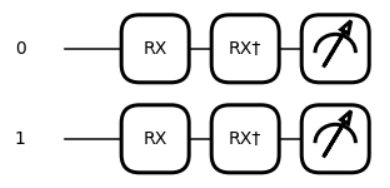
     
                         figure 3
                         
Another top combination is with scale status of **False** and PCA status of **True** with **two** PCs, using **amplitude-qiskit** embedding, with an accuracy of 97 percent. This model uses a single qubit, and has a depth of max two. (The figure below is simply an example, as we cannot draw RFV without values.)

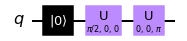
     
                         figure 4
 
We can see the full table for the top scores below :
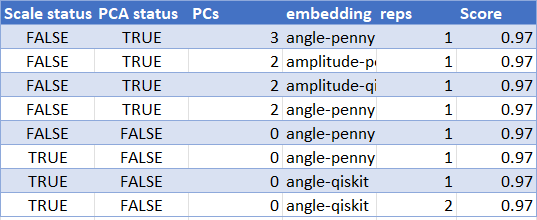

And for reference, the full table for the entirety of the experiment :
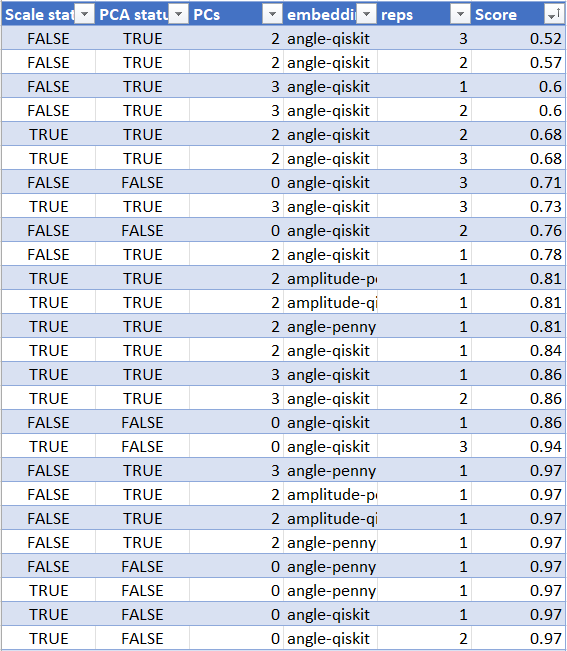

Let's establish some statistical knowledge from this dataset. We can observe :

1. By **increasing** the number of **reps**, the **accuracy decreases**.
2. By applying **PCA**, the **accuracy slightly drops** and **keeps dropping** as we **decrease** the number of **Principal Componennts**. (However, it provides a **trade-off** between **accuracy** and **depth**, meaning we can have a shallower PQC with a high enough accuracy)
3. We can also see how we can use a **single qubit**, with a **shallow depth** using **amplitude-qiskit** as well as **amplitude-pennylane**, which makes these two encodings the **most efficient**.
4. **Scaling** slightly **improves** the result in case of angle encoding, but not so for amplitude encoding.

Overall, the main points are to observe the tradeoff between the scale of the problem and its accuracy using PCA and encoder, and to achieve an even shallower representation, to exploit the amplitude encoding protocols. What we did in this model was to develop an understanding of the key components that build up QSVM, and how they compare to classical SVM in terms of cost and accuracy for the iris dataset.